In [1]:
'''
def get_StratifiedShuffleSplit(batches_idx,batch_size):
    n_bins  = 5
    batch_size = 5*7*7
    y_classes = df['steering'].copy()*n_bins//1
    batches_idx = df.index
    data_size = len(batches_idx)
    n_split = int(data_size//batch_size)-1
    print(n_split)
    batch_range = df.index
    sss = StratifiedShuffleSplit(n_splits = n_split,test_size = 15)
    batch_idx, val_idx = next(sss.split((batch_range),(y_classes.values)))
    
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    
    return batch_idx, val_idx

    batch_idx, val_idx = (get_batch_idx(batches_idx,batch_size = 256))
    batch_idx.shape
    
    #from keras.layers.recurrent import LSTM, GRU, SimpleRNN
#from keras.layers.wrappers import TimeDistributed
#from keras.regularizers import l2, activity_l2


'''

"\ndef get_StratifiedShuffleSplit(batches_idx,batch_size):\n    n_bins  = 5\n    batch_size = 5*7*7\n    y_classes = df['steering'].copy()*n_bins//1\n    batches_idx = df.index\n    data_size = len(batches_idx)\n    n_split = int(data_size//batch_size)-1\n    print(n_split)\n    batch_range = df.index\n    sss = StratifiedShuffleSplit(n_splits = n_split,test_size = 15)\n    batch_idx, val_idx = next(sss.split((batch_range),(y_classes.values)))\n    \n    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))\n    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))\n    \n    return batch_idx, val_idx\n\n    batch_idx, val_idx = (get_batch_idx(batches_idx,batch_size = 256))\n    batch_idx.shape\n    \n    #from keras.layers.recurrent import LSTM, GRU, SimpleRNN\n#from keras.layers.wrappers import TimeDistributed\n#from keras.regularizers import l2, activity_l2\n\n\n"

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

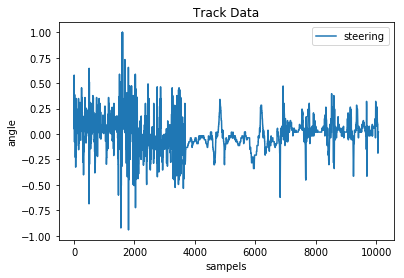

In [3]:
# read csv
def get_csv(path):
    # load CSV & drop zeros
    df = pd.read_csv(path+'driving_log.csv')
    df = df.drop(df[df['steering'] == 0.].index)
    df = df.drop(df[df['speed'] < 1.].index)
    df['center'] = path+df['center']
    df['right'] = path+df['right']
    df['left'] = path+df['left']
    return df

tracks = [get_csv(path = './data/'),\
          get_csv(path = './andy_track1_forward/'),\
          get_csv(path = './andy_track1_backward/')]
df = pd.concat(tracks).reset_index()

def plot_steering(df):
    ### plot 
    plt.plot(df['steering'])
    plt.title('Track Data')
    plt.ylabel('angle')
    plt.xlabel('sampels')
    plt.legend(['steering'], loc='upper right')
    #plt.yscale('log')
    plt.show()
    
plot_steering(df)

In [4]:
# split
split_index = int((1-(1/11))*(len(df)))
df_train = df[:split_index]
df_val  = df[split_index:]

In [5]:
# generate batch

from sklearn.utils import shuffle

image_shape = (160,320,3) #cv2.imread( df['center'][df['center'].index[0]]).shape
batch_size = 7 # 3675 = 3*5*5*7*7

def get_batch(df,batch_size): 
    n_split = int(len(df)//batch_size)-1
    batch_idx = (df[:batch_size*n_split].index.values)   
    batch_idx = shuffle(batch_idx)
    batch_idx = batch_idx.reshape(n_split,batch_size,)
    while 1:
        for idx in batch_idx:
            batch_y_c      =      df['steering'][idx].values 
            batch_y_r      =      df['steering'][idx].values - 0.2
            batch_y_l      =      df['steering'][idx].values + 0.2
            batch_y = np.concatenate([batch_y_c,batch_y_r,batch_y_l])
            batch_y = np.concatenate([batch_y,-batch_y])

            batch_x_path_c = df['center'][idx]
            batch_x_path_r = df['right'][idx]
            batch_x_path_l = df['left'][idx]
            batch_x_path = np.concatenate([batch_x_path_c,batch_x_path_r,batch_x_path_l])

            batch_x      = np.empty(list([batch_size*3]) + list(image_shape))
            ii = 0
            for img_path in batch_x_path:
                image = cv2.imread(img_path)
                #image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) ## COLOR_RGB2HSV COLOR_RGB2HLS
                batch_x[ii] = image
                ii +=1
                
            batch_x = np.concatenate([batch_x,batch_x[:,:,-1::-1]])

            assert(not(np.isnan((np.sum(batch_x)))))
            assert(not(np.isnan((np.sum(batch_y)))))
            yield shuffle(batch_x,batch_y) 

train_generator = get_batch(df_train, batch_size=batch_size)
validation_generator = get_batch(df_val, batch_size=batch_size)

batch_x,batch_y = next(train_generator)

In [6]:
def visualise_dataset(image,label,steps):
    plt_num = 1
    print(image.shape)
    step_size = int(image.shape[0]/steps)
    for image_idx in range(0,image.shape[0],step_size):
        channels = image.shape[3]
        plt.figure(plt_num, figsize=(32,32))
        for channel in range(channels):
            plt.subplot(4,8, channel+1) # sets the number of feature maps to show on each row and column
            plt.title('channel ' + str(channel)) # displays the feature map number
            plt.imshow(image[image_idx,:,:, channel], interpolation="nearest", cmap="gray")
        plt.show()
        print('steering: {1}, idx: {0}'.format(image_idx,label[image_idx],))
        
#%time visualise_dataset(batch_x,batch_y,steps=6)

In [ ]:
from keras.models import Sequential,load_model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge

import tensorflow as tf
import matplotlib

# Hyperparameter Compile
loss= 'mse' # 'hinge'
optimizer= 'Nadam' #'Nadam' #'rmsprop'
# Hyperparameter Fit
nb_epoch= 1

#print(Convolution2D.__doc__)
def input_layers():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=image_shape))
    #model.add(Lambda(lambda x: (x[:,:,:,0:1]+x[:,:,:,1:2]+x[:,:,:,2:3])/3)) ## drive on red
    model.add(Lambda(lambda x: x/127.5 - 1.))
    return model

def nvidia():
    model = input_layers()
    model.add(Convolution2D(nb_filter = 24,nb_row = 5,nb_col = 5,subsample=(2, 2),activation='relu'))
    model.add(Convolution2D(nb_filter = 36,nb_row = 5,nb_col = 5,subsample=(2, 2),activation='relu'))
    model.add(Convolution2D(nb_filter = 48,nb_row = 5,nb_col = 5,subsample=(2, 2),activation='relu'))
    model.add(Convolution2D(nb_filter = 64,nb_row = 3,nb_col = 3,subsample=(1, 1),activation='relu'))
    model.add(Convolution2D(nb_filter = 64,nb_row = 3,nb_col = 3,subsample=(1, 1),activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    return model

def lenet():
    model = input_layers()
    model.add(Convolution2D(12, 5, 5, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(25, 5, 5, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(180, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = 'relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'linear'))
    return model

def comma_ai():
    """ Example model from https://github.com/commaai/research
    """
    model = input_layers()
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(Dense(512, activation = 'elu'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation = 'linear'))
    return model

def model_bak():
    """ Example model from https://github.com/commaai/research
    """
    model = input_layers()
    model.add(Convolution2D(16, 8, 8, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(Dense(512, activation = 'elu'))
    model.add(Dropout(.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'elu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'linear'))
    return model

def model():
    model = input_layers()
    model.add(Convolution2D(16, 9, 9, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(32, 7, 7, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(256, 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dropout(.5))
    #model.add(BatchNormalization())
    model.add(Dense(1024, activation = 'elu'))
    
    model.add(Dropout(.5))
    model.add(BatchNormalization())
    model.add(Dense(512, activation = 'linear'))
    
    model.add(Dense(1, activation = 'linear'))
    return model




model = model()
print("model initialised")


try:
    #model = load_model('model.h5')
    model.load_weights("model.h5")
    print("load_weights done")
except:
    print("load_weights failed")

%time model.compile(loss=loss, optimizer=optimizer)

min_loss = 17
while(1):
    history_object = model.fit_generator(generator         = train_generator, \
                        samples_per_epoch = batch_size*6, \
                        validation_data   = validation_generator, \
                        nb_val_samples    = 1, \
                        nb_epoch          = nb_epoch)
    model.save("model_latest.h5")

    if(history_object.history['val_loss'][-1] < min_loss):
        min_loss = history_object.history['val_loss']
        model.save("model.h5")
        print('model saved')
        #break



import winsound
winsound.Beep(130,1000)

model initialised
load_weights failed
Wall time: 402 ms
Epoch 1/1
42/42 [==============================] - 26s - loss: 1.6763 - val_loss: 0.1553
model saved
Epoch 1/1
42/42 [==============================] - 9s - loss: 1.8764 - val_loss: 2.1641
Epoch 1/1
42/42 [==============================] - 10s - loss: 7.2943 - val_loss: 1594.5736
Epoch 1/1
42/42 [==============================] - 10s - loss: 24.0412 - val_loss: 9052.2090
Epoch 1/1
42/42 [==============================] - 10s - loss: 7.5189 - val_loss: 71.6331
Epoch 1/1
42/42 [==============================] - 10s - loss: 4.2928 - val_loss: 1124.0768
Epoch 1/1
42/42 [==============================] - 10s - loss: 4.7102 - val_loss: 385.3517
Epoch 1/1
42/42 [==============================] - 10s - loss: 5.2425 - val_loss: 176.9426
Epoch 1/1
42/42 [==============================] - 9s - loss: 3.8122 - val_loss: 27.2918
Epoch 1/1
42/42 [==============================] - 10s - loss: 2.0549 - val_loss: 39.2830
Epoch 1/1
42/42 [==========

In [ ]:
def plot_history_object(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.yscale('log')
    plt.show()

plot_history_object(history_object)



In [ ]:
import argparse
import base64
from datetime import datetime
import os
import shutil

import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

from keras.models import load_model
import h5py
from keras import __version__ as keras_version

model = load_model('model.h5')
print("load_model done")

sio = socketio.Server()
app = Flask(__name__)
prev_image_array = None


class SimplePIController:
    def __init__(self, Kp, Ki):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = 0.
        self.error = 0.
        self.integral = 0.

    def set_desired(self, desired):
        self.set_point = desired

    def update(self, measurement):
        # proportional error
        self.error = self.set_point - measurement
        # integral error
        self.integral += self.error
        return self.Kp * self.error + self.Ki * self.integral

controller = SimplePIController(0.1, 0.002)
set_speed = 15
controller.set_desired(set_speed)

@sio.on('telemetry')
def telemetry(sid, data):
    if data:
        # The current steering angle of the car
        steering_angle = data["steering_angle"]
        # The current throttle of the car
        throttle = data["throttle"]
        # The current speed of the car
        speed = data["speed"]
        # The current image from the center camera of the car
        imgString = data["image"]
        image = Image.open(BytesIO(base64.b64decode(imgString)))
        image_array = np.asarray(image)
        steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
        throttle = controller.update(float(speed))
        print(steering_angle, throttle)
        send_control(steering_angle, throttle)
    else:
        # NOTE: DON'T EDIT THIS.
        sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': steering_angle.__str__(),
            'throttle': throttle.__str__()
        },
        skip_sid=True)

# wrap Flask application with engineio's middleware
app = socketio.Middleware(sio, app)

# deploy as an eventlet WSGI server
eventlet.wsgi.server(eventlet.listen(('', 4567)), app)
